In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
np.random.seed(5293)

n = 30
n_true = 100000
mean = 0.2
std = 0.7
lower, upper = -1.5, 2


a_dist = stats.truncnorm((lower - mean) / std, (upper - mean) / std, loc=mean, scale=std)
a_samples = a_dist.rvs(n)
a_samples_true = a_dist.rvs(n_true)


alpha = 3
beta = 1
sigma2_samples = stats.invgamma(a=alpha, scale=beta).rvs(n)
sigma2_samples_true = stats.invgamma(a=alpha, scale=beta).rvs(n_true)
sigma_samples = np.sqrt(sigma2_samples)
sigma_samples_true = np.sqrt(sigma2_samples_true)

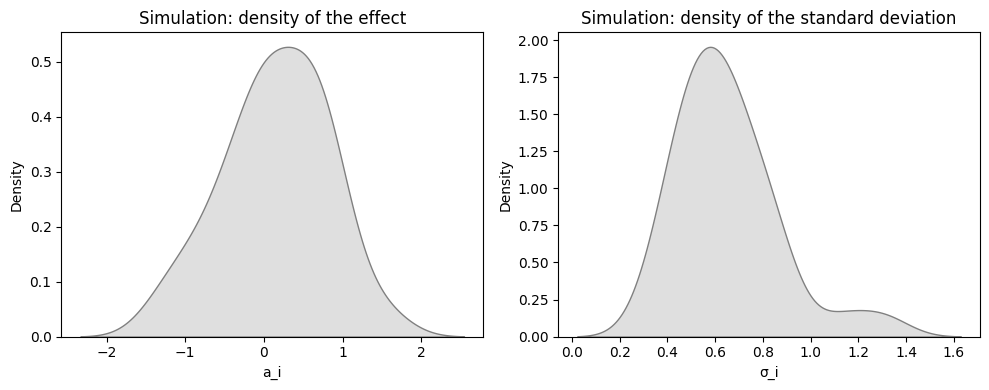

In [3]:
# Sample Density Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(a_samples, ax=axes[0], fill=True, color="gray")
axes[0].set_title("Simulation: density of the effect")
axes[0].set_xlabel("a_i")
axes[0].set_ylabel("Density")

sns.kdeplot(sigma_samples, ax=axes[1], fill=True, color="gray")
axes[1].set_title("Simulation: density of the standard deviation")
axes[1].set_xlabel("σ_i")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

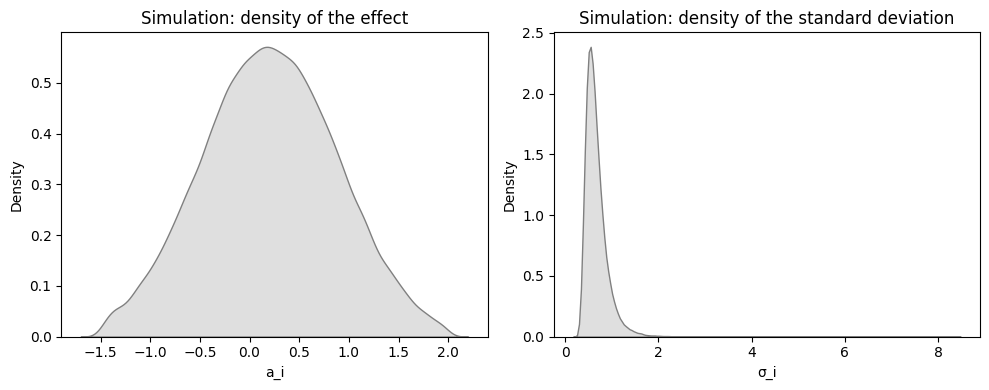

In [4]:
# True Distribution Density Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.kdeplot(a_samples_true, ax=axes[0], fill=True, color="gray")
axes[0].set_title("Simulation: density of the effect")
axes[0].set_xlabel("a_i")
axes[0].set_ylabel("Density")

sns.kdeplot(sigma_samples_true, ax=axes[1], fill=True, color="gray")
axes[1].set_title("Simulation: density of the standard deviation")
axes[1].set_xlabel("σ_i")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

# Step 1: Ran 1000 Times

In [5]:
from scipy.stats import norm

def truncated_posterior_mean(y, sigma, mu0=0.2, tau=0.7, threshold=1.96):
    # Prior: a ~ N(mu0, tau^2)
    # Posterior: a | y ~ N(mu_i, tau_i^2)
    tau2_i = 1 / (1 / tau**2 + 1 / sigma**2)
    mu_i = tau2_i * (mu0 / tau**2 + y / sigma**2)

    # Truncation: only if y > threshold * sigma
    a_min = threshold * sigma

    z = (a_min - mu_i) / np.sqrt(tau2_i)
    lambda_z = norm.pdf(z) / (1 - norm.cdf(z))

    posterior_mean_trunc = mu_i + np.sqrt(tau2_i) * lambda_z
    return posterior_mean_trunc


In [6]:
def simulate(n=30, seed=5293):


    n = 30
    mean = 0.2
    std = 0.7
    lower, upper = -1.5, 2

    a_dist = stats.truncnorm((lower - mean) / std, (upper - mean) / std, loc=mean, scale=std)
    a_i = a_dist.rvs(n)

    alpha = 3
    beta = 1
    sigma2_i = stats.invgamma(a=alpha, scale=beta).rvs(n)
    sigma_i = np.sqrt(sigma2_samples)

    y_i = np.random.normal(loc=a_i, scale=sigma_i)

    significant = y_i > 1.96 * sigma_i

    SA = np.sum(y_i[significant])                   # naive total effect
    TAc = np.sum(truncated_posterior_mean(y_i[significant], sigma_i[significant]))  # use Empirical Bayes posterior mean to compute 'c'
    TAhat = np.sum(y_i)                               # all observed effect
    TAtrue = np.sum(a_i[significant])                 # sum of true effect among significant
    beta = SA - TAtrue                                # bias
    size = np.sum(significant)                        # number of significant results

    return size, SA, TAc, TAhat, TAtrue, beta


In [7]:
results = [simulate() for _ in range(1000)]

import pandas as pd
df = pd.DataFrame(results, columns=["|A|", "S_A", "T_A_cond", "T_A_hat", "T_A", "beta"])

summary = df.describe(percentiles=[0.25, 0.5, 0.75]).loc[["min", "25%", "50%", "mean", "75%", "max"]]
summary.index = ["Min", "1Q", "2Q", "Mean", "3Q", "Max"]
summary_rounded = summary.round(2)
summary_rounded

,|A|,S_A,T_A_cond,T_A_hat,T_A,beta
Min,0.00,0.00,0.00,-10.83,-0.25,-0.60
1Q,3.00,4.56,4.27,2.31,2.76,1.35
2Q,4.00,6.60,6.08,5.76,4.05,2.34
Mean,4.29,6.84,6.30,5.80,4.24,2.60
3Q,5.00,8.87,8.18,9.28,5.54,3.62
Max,12.00,23.49,19.85,25.61,11.82,11.72


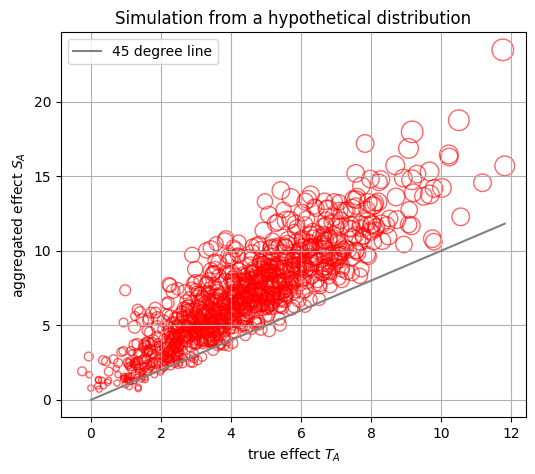

In [8]:
# Figure 3: S_A vs T_A
plt.figure(figsize=(6, 5))
plt.scatter(df["T_A"], df["S_A"], s=df["|A|"]*20, c='none', alpha=0.6, edgecolors='r')
plt.plot([0, df["T_A"].max()], [0, df["T_A"].max()], 'gray', label='45 degree line')
plt.xlabel("true effect $T_A$")
plt.ylabel("aggregated effect $S_A$")
plt.title("Simulation from a hypothetical distribution")
plt.legend()
plt.grid(True)
plt.show()

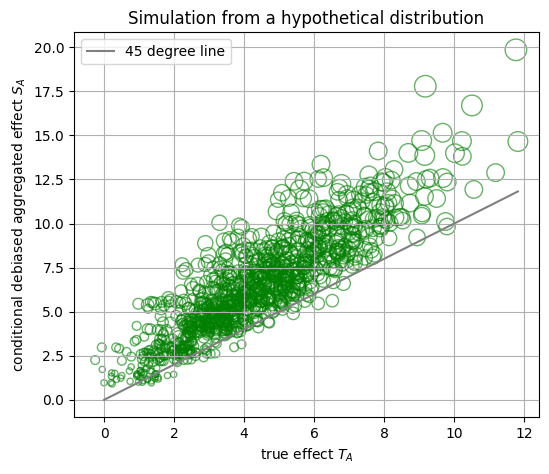

In [9]:
# Figure 4: T_A_cond vs T_A
plt.figure(figsize=(6, 5))
plt.scatter(df["T_A"], df["T_A_cond"], s=df["|A|"]*20, c='none', alpha=0.6, edgecolors='g')
plt.plot([0, df["T_A"].max()], [0, df["T_A"].max()], 'gray', label='45 degree line')
plt.xlabel("true effect $T_A$")
plt.ylabel("conditional debiased aggregated effect $S_A$")
plt.title("Simulation from a hypothetical distribution")
plt.legend()
plt.grid(True)
plt.show()

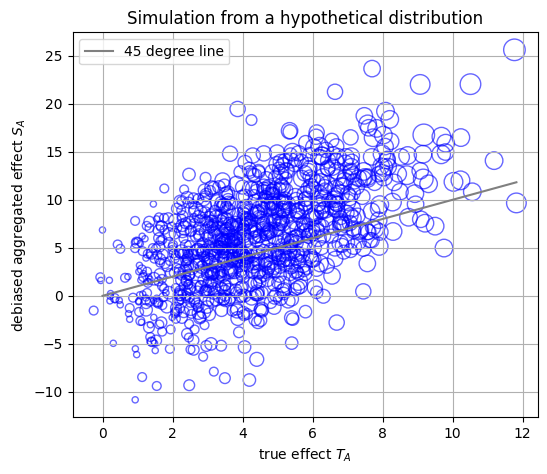

In [10]:
# Figure : T_A_hat vs T_A
plt.figure(figsize=(6, 5))
plt.scatter(df["T_A"], df["T_A_hat"], s=df["|A|"]*20, c='none', alpha=0.6, edgecolors='b')
plt.plot([0, df["T_A"].max()], [0, df["T_A"].max()], 'gray', label='45 degree line')
plt.xlabel("true effect $T_A$")
plt.ylabel("debiased aggregated effect $S_A$")
plt.title("Simulation from a hypothetical distribution")
plt.legend()
plt.grid(True)
plt.show()


# Constructing CI

In [11]:
def simulate_1(n=30, mean=0.2, std=0.7, lower=-1.5, upper=2, alpha=3, beta=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    # Truncated normal for a_i
    a_dist = stats.truncnorm((lower - mean) / std, (upper - mean) / std, loc=mean, scale=std)
    a_i = a_dist.rvs(n)
    # Inverse gamma for sigma^2
    sigma2_i = stats.invgamma(a=alpha, scale=beta).rvs(n)
    sigma_i = np.sqrt(sigma2_i)
    y_i = np.random.normal(loc=a_i, scale=sigma_i)
    significant = y_i > 1.96 * sigma_i
    return y_i, sigma_i, a_i, significant

In [12]:
def bootstrap_CI(y, sigma, estimator_fn, B=1000, alpha=0.05):
    n = len(y)
    estimates = []
    for _ in range(B):
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        y_boot = y[idx]
        sigma_boot = sigma[idx]
        estimates.append(estimator_fn(y_boot, sigma_boot))
    lower = np.percentile(estimates, 100 * alpha / 2)
    upper = np.percentile(estimates, 100 * (1 - alpha / 2))
    return lower, upper


In [13]:
def naive_estimator(y, sigma):
    return np.sum(y)

def debiased_estimator(y, sigma):
    return np.sum(truncated_posterior_mean(y, sigma))

def empirical_bayes_estimator(y, sigma):
    return np.sum(truncated_posterior_mean(y, sigma))

In [14]:
def simulate_with_CI(B, n_sims, alphas=[0.3, 0.2, 0.1, 0.05]):
    results = {alpha: {'Naive': [], 'Bootstrap': [], 'Debiased': []} for alpha in alphas}

    for _ in range(n_sims):
        y, sigma, a, sig = simulate_1()
        if np.sum(sig) == 0:
            for alpha in alphas:
                results[alpha]['Naive'].append(np.nan)
                results[alpha]['Bootstrap'].append(np.nan)
                results[alpha]['Debiased'].append(np.nan)
            continue

        y_sig = y[sig]
        sigma_sig = sigma[sig]
        a_sig = a[sig]
        T_A_true = np.sum(a_sig)

        for alpha in alphas:
            # Naive CI
            mean_naive = np.sum(y_sig)
            var_naive = np.sqrt(np.sum(sigma_sig**2))
            lower_naive = mean_naive - norm.ppf(1 - alpha / 2) * var_naive
            upper_naive = mean_naive + norm.ppf(1 - alpha / 2) * var_naive
            results[alpha]['Naive'].append(lower_naive <= T_A_true <= upper_naive)

            # Bootstrap CI (on naive)
            lower_b, upper_b = bootstrap_CI(y_sig, sigma_sig, naive_estimator, B=B, alpha=alpha)
            results[alpha]['Bootstrap'].append(lower_b <= T_A_true <= upper_b)

            # Debiased Bootstrap CI
            lower_d, upper_d = bootstrap_CI(y_sig, sigma_sig,
                                            lambda y, s: debiased_estimator(y, s),
                                            B=B, alpha=alpha)
            results[alpha]['Debiased'].append(lower_d <= T_A_true <= upper_d)

    # summarize
    data = []
    for alpha in alphas:
        target = 1 - alpha
        naive_cov = np.nanmean(results[alpha]['Naive'])
        boot_cov = np.nanmean(results[alpha]['Bootstrap'])
        debias_cov = np.nanmean(results[alpha]['Debiased'])
        data.append((target, naive_cov, boot_cov, debias_cov))
    df_result = pd.DataFrame(data, columns=["Target Coverage", "Naive", "Bootstrap", "Debiased Bootstrap"])
    return df_result


In [ ]:
df_ci_summary_safe = simulate_with_CI(B=1000, n_sims=1000)
df_ci_summary_safe